## Practice 6-1

In [3]:
from dotenv import load_dotenv
load_dotenv()

import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [10]:
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document
from typing import Annotated, List, Dict, Any
from langgraph.graph import StateGraph, START, END

from langchain_core.documents import Document

class CafeState(MessagesState):
    """카페 시스템 상태 클래스"""
    query_type: str = ""  
    search_results: List[Dict] = []  
    user_preferences: Dict[str, Any] = {}

In [21]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from textwrap import dedent

embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 


# menu db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "./db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

llm = ChatOpenAI(model="gpt-4o-mini")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = cafe_db.as_retriever(
    search_kwargs={"k": 6}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

class CafeState(MessagesState):
    # messages 키는 기본 제공 - 다른 키를 추가하고 싶을 경우 아래 주석과 같이 적용 가능 
    question: str
    documents: List[Document]
    generation: str

In [28]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.tools import tool

# 라우팅 결정을 위한 데이터 모델
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_menu", "search_price", "recommend_menu"] = Field(
        description="Select one of the tools: search_menu, search_price or recommend_menu based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm = llm.with_structured_output(ToolSelector)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""You are an AI assistant specializing in routing user questions to the appropriate tool.
Use the following guidelines:
- For questions about the restaurant's menu, use the search_menu tool.
- For wine recommendations or pairing information, use the search_wine tool.
- For any other information or the most up-to-date data, use the search_web tool.
Always choose the most appropriate tool based on the user's question.""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 정의
question_router = route_prompt | structured_llm

@tool
def search_menu(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=4)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

@tool
def search_price(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=4)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 가격 정보를 찾을 수 없습니다."

@tool
def recommend_menu(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = cafe_db.similarity_search(query, k=4)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 추천 정보를 찾을 수 없습니다."
    
tools = [search_menu, search_price, recommend_menu]
llm_with_tools = llm.bind_tools(tools)
# 테스트 실행
print(question_router.invoke({"question": "아메리카노는 얼마인가요??"}))
print(question_router.invoke({"question": "커피 종류는 뭐가 있나요?"}))
print(question_router.invoke({"question": "디저트를 추천해주세요."}))

tool='search_price'
tool='search_menu'
tool='recommend_menu'


## ReAct Agent

<class 'langgraph.graph.state.CompiledStateGraph'>


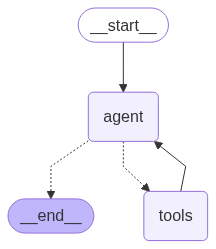

In [22]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(
    llm, 
    tools=tools, 
)

print(type(graph))

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="커피 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

커피 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_price (call_FBd6UDUukQQNT5w2jO1R0TDT)
 Call ID: call_FBd6UDUukQQNT5w2jO1R0TDT
  Args:
    query: 커피
================================= Tool Message =================================
Name: search_price

<Document source="./data/cafe_menu_data.txt"/>
6. 콜드브루
   • 가격: ₩5,000
   • 주요 원료: 콜드브루 원액, 차가운 물
   • 설명: 찬물에 12-24시간 우려낸 콜드브루 원액을 사용한 시원한 커피입니다. 부드럽고 달콤한 맛이 특징이며, 산미가 적어 누구나 부담 없이 즐길 수 있습니다. 얼음과 함께 시원하게 제공됩니다.
</Document>

---

<Document source="./data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="./data/cafe_menu_data.txt"/>
5. 카라멜 마키아토
   • 가격: ₩6,500
   • 주요 원료: 에스프레소, 스팀 밀크, 카라멜 시럽, 휘핑크림
   • 설명: 스팀 밀크 위에 에스프레소를 부어 만

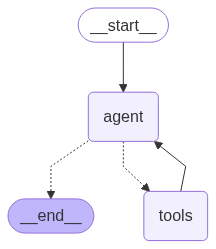

In [ ]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import SystemMessage

# 시스템 프롬프트
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    #state_modifier=system_prompt,
    #system_message=SystemMessage(content=system_prompt),
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))


In [25]:
# 그래프 실행
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="커피 메뉴의 가격은 얼마인가요?")
    ]
#inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
#messages = graph.invoke(inputs)

messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크

    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니